# Notebook for CTM

## Imports and parameter settings

In [98]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from loguru import logger

from typing import List, Optional

# sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering 
from sklearn.metrics import silhouette_score, davies_bouldin_score

# our models
from models.cluster import ClusterModel
from models.cluster import KMeansClusterModel, DBSCANClusterModel, HierarchicalClusterModel

# utils
from utils.tf_idf import tfidf_cluster_summary, tfidf_cluter_per_column
from utils.load import load_ctms_dataset
# from utils.metrics import davies_bouldin_score, silhouette_score,
from utils.metrics import column_wise_summary

# -------- plot settings ----------

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    # --- Figure ---
    "figure.figsize": (6, 4),
    "figure.dpi": 300,

    # --- Fonts ---
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "font.family": "serif",       # or "sans-serif"
    "mathtext.fontset": "stix",   # clean math font

    # --- Axes ---
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.grid": False,

    # --- Ticks ---
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.major.width": 0.7,
    "ytick.major.width": 0.7,

    # --- Legend ---
    "legend.fontsize": 10,
    "legend.frameon": False,

    # --- Colors / Colormap ---
    "image.cmap": "viridis",
})



# Preprocessing of data

<tt>`ctm_to_array`</tt> to converts the series of CTM into a single stacked 2D array *X*. The <tt>`preprocess_ctms`</tt> function standardizes X, applies Principal Component Analysis (PCA) to reduce its dimensionality while retaining at least 90% of the variance, this is done in order to improve computational efficienciency. The function removes outliers in the new PCA-array using the Interquartile Range (IQR) on each principal component. The function returns the filtered DataFrame and the resulting PCA features.

In [99]:
def ctm_to_array(ctm_series: pd.Series) -> np.ndarray:
    """Convert CTMs into a stacked 2D array."""
    ctm_arrays = np.vstack([
        ctm.flatten() if isinstance(ctm, np.ndarray) else ctm
        for ctm in ctm_series
    ])

    return ctm_arrays

def preprocess_ctms(
    df: pd.DataFrame,
    remove_outliers: bool = True,
    iqr_multiplier: float = 2.5
):
    """Convert CTMs -> PCA -> optional outlier filtering."""
    X = ctm_to_array(df["ctm"])

    # Standardize
    X_scaled = StandardScaler().fit_transform(X)

    # PCA full, then select cutoff at ≥90% explained variance
    k = 30
    logger.info(f"CTMs: PCA -> {k} dims (≥90% variance)")

    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_scaled)

    # Outlier removal
    if remove_outliers:
        mask = np.ones(len(X_pca), dtype=bool)
        for j in range(X_pca.shape[1]):
            q1, q3 = np.percentile(X_pca[:, j], [25, 75])
            iqr = q3 - q1
            lb, ub = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr
            mask &= (X_pca[:, j] >= lb) & (X_pca[:, j] <= ub)

        logger.info(f"Removed {(~mask).sum()} outliers.")
        return df[mask].reset_index(drop=True), X_pca[mask]

    return df.reset_index(drop=True), X_pca

# Cluster tuning
This code prepares the data by calling <tt>`preprocess_ctms`</tt> to transform and reduce the dimensionality of the CTMs into a feature array X. It iteratively tests multiple parameter values for K-Means (varying k) and DBSCAN (varying $\epsilon$), calculating the Silhouette Score (for measuring cluster separability) and the Davies-Bouldin Index (for measuring within-cluster similarity and between-cluster differences).

It doesn't run the Hieracial Cluster model as it is very memory and time demanding, running in $O(n^3)$ time. 

[//]: # "Maybe we should mention something about the results for the Hieracial Cluster model if we end up running them?"


In [100]:
def tune_clusters(
    df: pd.DataFrame,
    k_list: Optional[List[int]] = None,
    eps_list: Optional[List[float]] = None,
    n_clusters_list: Optional[List[int]] = None,
    save_path: str = "results/ctms_general",

):
    """
    Unified cluster tuning function.
    Returns silhouette scores for KMeans, DBSCAN, Hierarchical.
    """
    logger.info("Preprocessing CTMs...")
    df_proc, X = preprocess_ctms(df)

    silhouette_scores = {
        "kmeans": {},
        "dbscan": {},
        "hierarchical": {}
    }
    davies_bouldin_scores = {
        "kmeans": {},
        "dbscan": {},
        "hierarchical": {}
    }

    # ---- KMeans ----
    if k_list:
        for k in tqdm(k_list, desc="Tuning KMeans"):
            # model = KMeansClusterModel(n_clusters=k)
            model = KMeans(n_clusters=k, random_state=42)
            labels = model.fit_predict(X)
            silhouette_scores["kmeans"][k] = silhouette_score(X, labels)
            davies_bouldin_scores["kmeans"][k] = davies_bouldin_score(X, labels)

    # ---- DBSCAN ----
    if eps_list:
        for eps in tqdm(eps_list, desc="Tuning DBSCAN"):
            model = DBSCAN(eps=eps, min_samples=5)
            model.fit(X)
        labels = model.labels_

        # silhouette requires ≥2 clusters and no noise-label issues
        if len(set(labels)) > 1 and -1 not in labels:
            silhouette_scores["dbscan"][eps] = silhouette_score(X, labels)
            davies_bouldin_scores["dbscan"][eps] = davies_bouldin_score(X, labels)
        else:
            score = -1

        silhouette_scores["dbscan"][eps] = score
        davies_bouldin_scores["dbscan"][eps] = None  # invalid

    # ---- Hierarchical ----
    # for n in tqdm(n_clusters_list, desc="Tuning Hierarchical"):
    #     model = HierarchicalClusterModel(n_clusters=n)
    #     labels = model.fit_predict(X)
    #     score = silhouette_score(X, labels)
    #     results["hierarchical"][n] = score

    score_path = f"{save_path}/ctm_tuning_scores.json"
    with open(score_path, "w") as f:
        json.dump({
            "silhouette": silhouette_scores,
            "davies_bouldin": davies_bouldin_scores
        }, f, indent=2)

    return silhouette_scores, davies_bouldin_scores


# Plotting
Gets the feature array X from <tt>`preprocess_ctms`</tt>. It applies the provided ClusterModel to _X_ to generate cluster labels, which are added to the DataFrame. It generates a scatter plot of the data points.

In [101]:
def plot_clusters(
    df: pd.DataFrame,
    model: ClusterModel,
    dim: int = 2,
    remove_outliers: bool = True,
    save_dir: str = "results/ctms_general/plots",
    model_name: str = "ctm"
):
    """
    Preprocess -> cluster -> plot PCA (2D/3D).
    """
    if dim not in (2, 3):
        raise ValueError("dim must be 2 or 3")

    df_proc, X = preprocess_ctms(df, remove_outliers=remove_outliers)

    labels = model.fit_predict(X)
    df_proc["cluster_label"] = labels

    # ---- 2D ----
    if dim == 2:
        plt.figure(figsize=(10, 8))
        s = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="tab10", alpha=0.7)
        plt.title(f"2D PCA clusters (CTM)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.tight_layout()
        save_path = f"{save_dir}/{model_name}_2D_clusters.png"
        plt.savefig(save_path, dpi=300)
        return df_proc

    # ---- 3D ----
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection="3d")
    s = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap="tab10", alpha=0.7)
    ax.set_title(f"3D PCA clusters (CTM)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.tight_layout()
    save_path = f"{save_dir}/{model_name}_3D_clusters.png"
    plt.savefig(save_path, dpi=300)
    return df_proc


In [102]:
def plot_variance_explained(df):
    """
    Computes PCA and plots the individual and cumulative explained variance
    for the first 100 principal components, with a marker at PC=30.
    """

    X = ctm_to_array(df["ctm"])

    X_scaled = StandardScaler().fit_transform(X)

    k = 100
    logger.info(f"CTMs: PCA -> computing variance explained for first {k} PCs")

    pca = PCA(n_components=k)
    pca.fit(X_scaled)

    individual_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(individual_var)

    plt.figure(figsize=(12, 6))

    plt.plot(range(1, k+1), cumulative_var, marker='s', label="Cumulative variance")

    pc_highlight = 30
    cum_at_30 = cumulative_var[pc_highlight - 1]

    plt.scatter(
        pc_highlight,
        cum_at_30,
        s=120,
        color="red",
        zorder=5,
        label=f"Cumulative at PC 30 = {cum_at_30:.2f}"
    )

    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Variance Explained by First 100 Principal Components")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    logger.info(
        f"Cumulative variance after 30 PCs: {cum_at_30:.4f} ({cum_at_30*100:.2f}%)"
    )

    return individual_var, cumulative_var

# TF-IDF metadata evaluation

Preprocessing the CTM data into features _X_ and applying the clustering model to assign a cluster_label to each row. It TF-IDF (Term Frequency-Inverse Document Frequency) to identify the top 10 most distinguishing terms for each cluster.

In [103]:
def evaluate_metadata(
    df: pd.DataFrame,
    model: ClusterModel,
    save_dir: str = "results/ctms_general/json"
):
    """
    Preprocess -> cluster -> TF-IDF global + per-column.
    Saves two JSON files.
    """
    df_proc, X = preprocess_ctms(df)
    df_proc["cluster_label"] = model.fit_predict(X)

    path_global = f"{save_dir}/ctms_tfidf_global.json"
    path_cols = f"{save_dir}/ctms_column_summary.json"

    tfidf_cluster_summary(
        df_proc,
        save_path=path_global,
        k=10,
        ngram_range=(1, 2),
        min_df=1,
        max_df=0.8,
    )

    column_wise_summary(
        df_proc,
        columns=["name", "themes", "keywords", "involved_companies", "first_release_year"],
        save_path=path_cols,
    )

    return df_proc


# Driver code
The <tt>tuning_pipeline_driver</tt> function loads the CTM dataset and then calls <tt> tune_clusters </tt> to evaluate a predefined range of hyperparameters to find the best clustering configuration.

In [104]:
def tuning_pipeline_driver():
    """
    Driver code for tuning CTM clustering models.
    """
    ctm_df = load_ctms_dataset("data/videogame_sequences/sequence_dataset.parquet")
    
    # n_clusters = [2, 4, 6, 10]
    eps_list = [0.5, 1.0, 1.5, 2.5, 5, 10, 50, 100]
    k_list = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20]

    logger.info("Tuning clustering for CTM representations…")
    tuning_results = tune_clusters(
        ctm_df,
        k_list=k_list,
        eps_list = eps_list,
    )
    logger.info(f"Tuning results: {tuning_results}")

def plotting_pipeline_driver():
    """
    Driver code for plotting embedding clustering results.
    """
    ctms_df = load_ctms_dataset("data/videogame_sequences/sequence_dataset.parquet")
    k = 6 
    n_clusters = 6
    eps = 3
    min_samples = 10

    # kmeans_model = KMeansClusterModel(n_clusters=k) # our own implementation - quite slow so using KMeans from Sklearn instead 
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    #dbscan_model = DBSCAN(eps=3, min_samples=10)
    #hiercial_model = HierarchicalClusterModel(n_clusters=6)

    logger.info(f"Plotting clustering for ctms with K={k}…")
    clustered_df = plot_clusters(
        ctms_df,
        model=kmeans_model,
        dim=2
    )

    # clustered_df = plot_clusters(
    #     ctms_df,
    #     model=dbscan_model,
    #     dim=2
    # )

    logger.info(f"Clustered DataFrame head:\n{clustered_df.head()}")


2025-12-02 19:25:53.601 | INFO     | __main__:plot_variance_explained:12 - CTMs: PCA -> computing variance explained for first 100 PCs


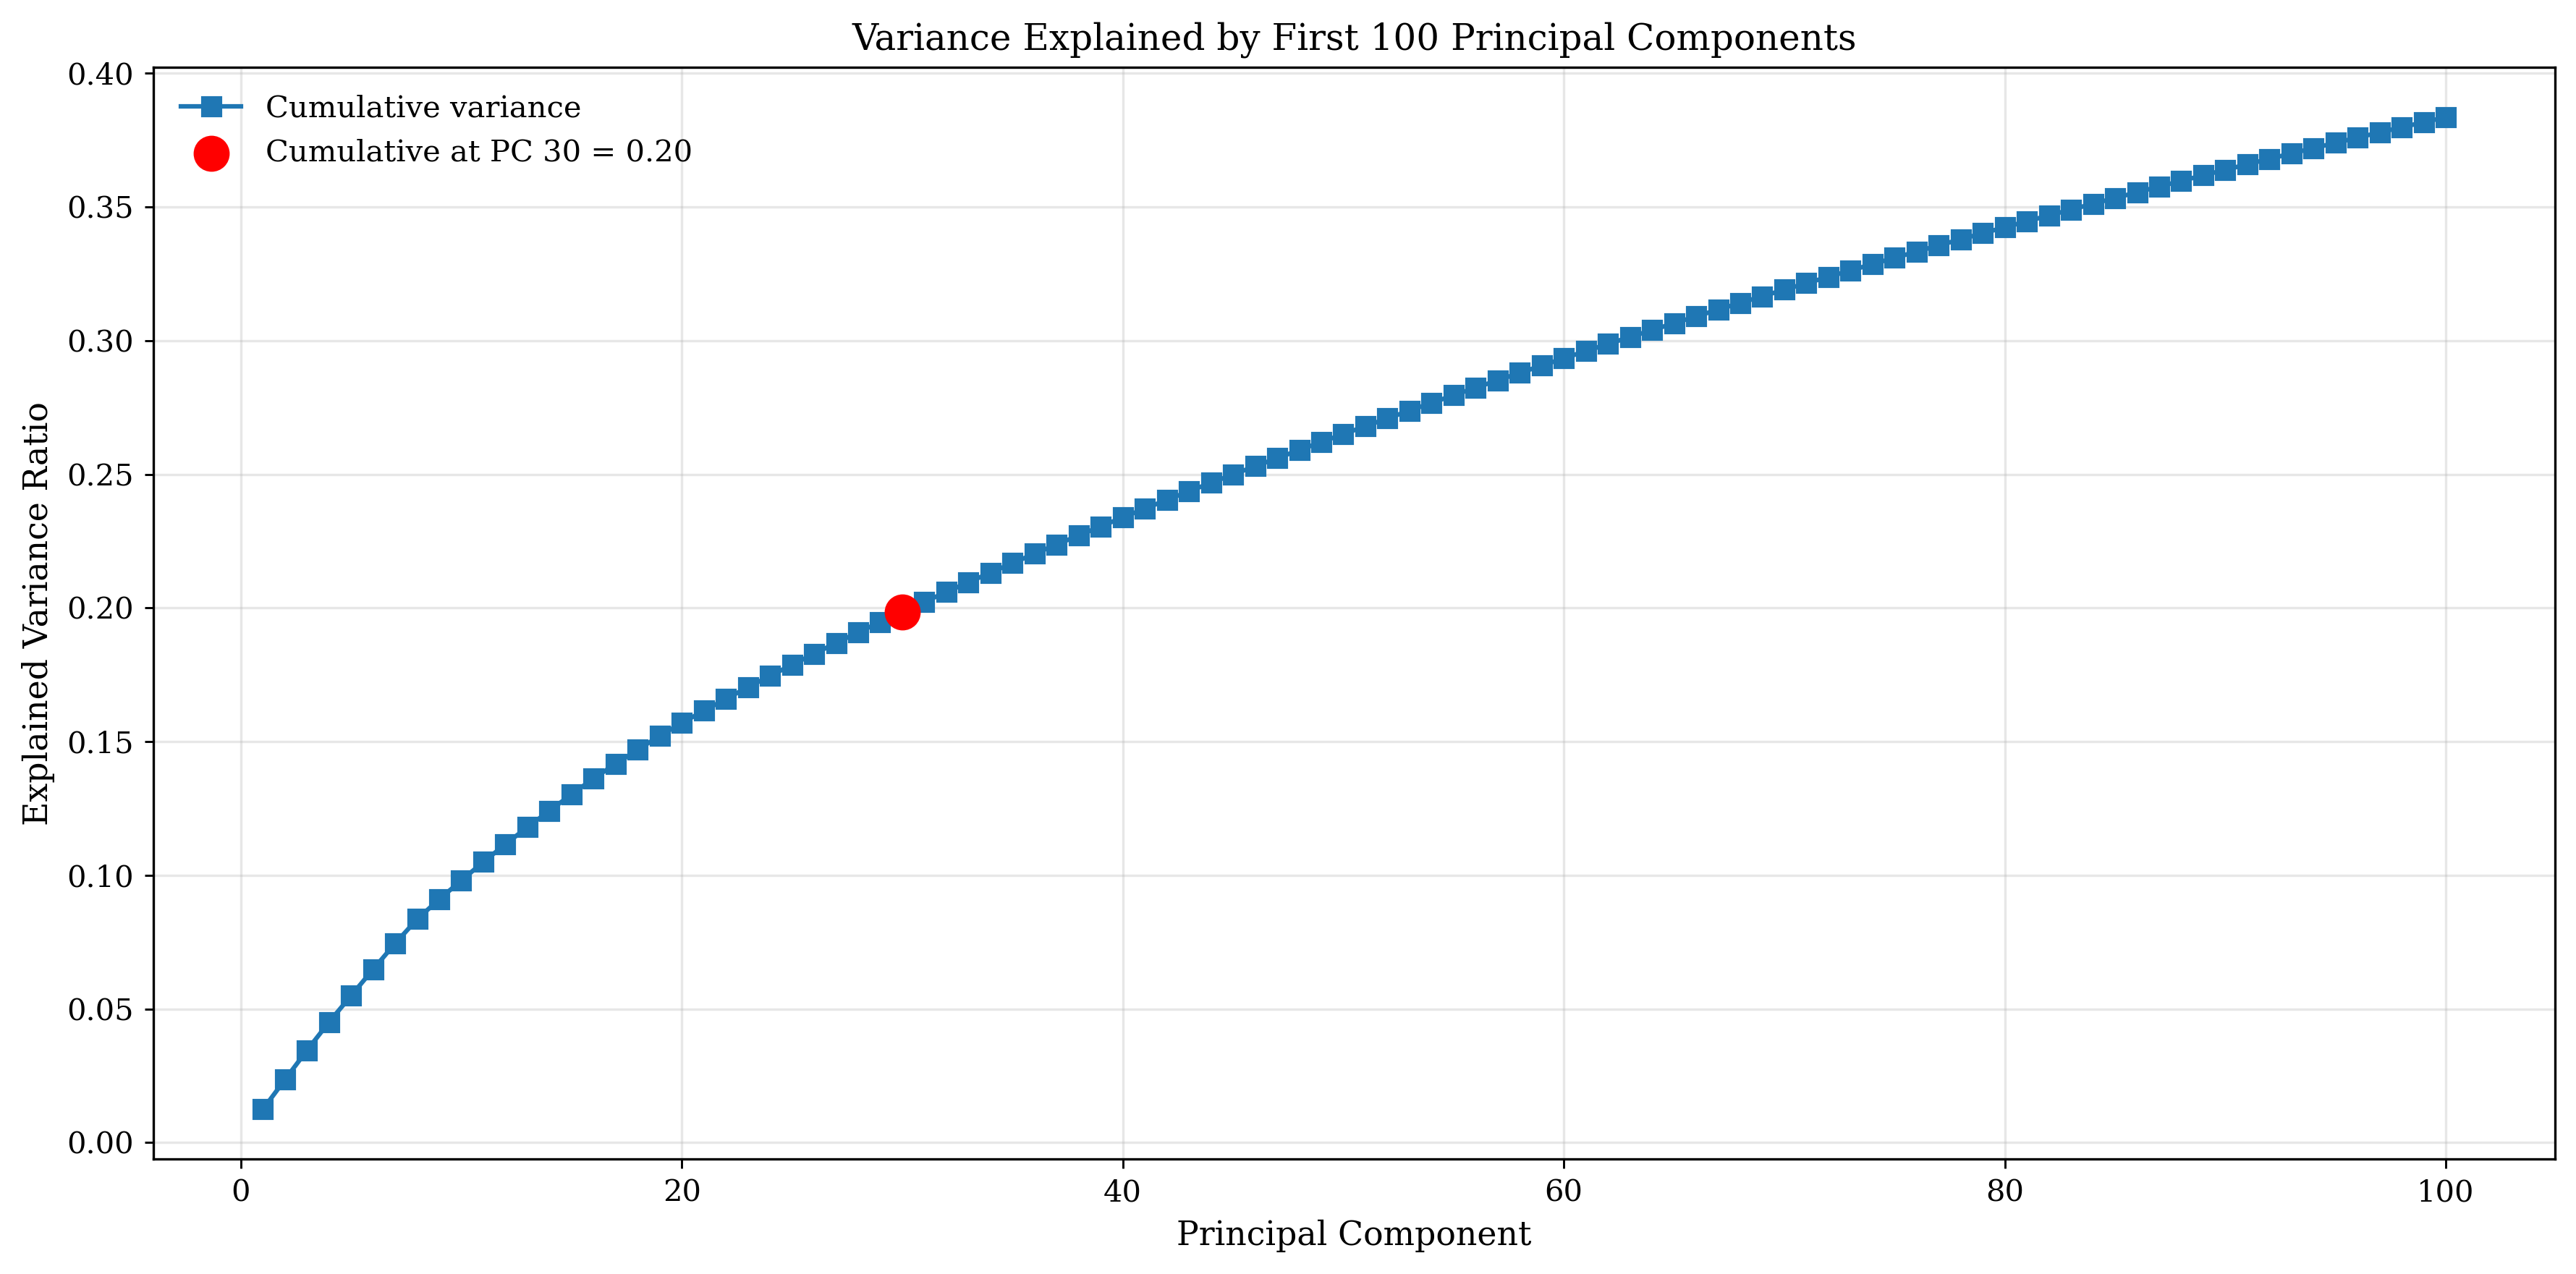

2025-12-02 19:25:56.491 | INFO     | __main__:plot_variance_explained:44 - Cumulative variance after 30 PCs: 0.1985 (19.85%)
2025-12-02 19:25:57.185 | INFO     | __main__:tuning_pipeline_driver:11 - Tuning clustering for CTM representations…
2025-12-02 19:25:57.186 | INFO     | __main__:tune_clusters:13 - Preprocessing CTMs...
2025-12-02 19:25:57.641 | INFO     | __main__:preprocess_ctms:23 - CTMs: PCA -> 30 dims (≥90% variance)
2025-12-02 19:25:59.296 | INFO     | __main__:preprocess_ctms:37 - Removed 942 outliers.
Tuning DBSCAN: 100%|██████████| 8/8 [00:00<00:00, 19.72it/s]
2025-12-02 19:26:00.607 | INFO     | __main__:tuning_pipeline_driver:17 - Tuning results: ({'kmeans': {2: 0.41847736680472425, 3: 0.4254674147790241, 4: 0.28739167530592596, 5: 0.3086669188980108, 6: 0.3077572372702398, 8: 0.26617914265869225, 10: 0.2767265518732001, 12: 0.25882552478548626, 15: 0.2578133722436501, 20: 0.2285853940210664}, 'dbscan': {100: -1}, 'hierarchical': {}}, {'kmeans': {2: 1.2805283370934457

,name,note_sequence,ctm,id,rating,themes,keywords,involved_companies,first_release_year,metadata,cluster_label
0,Star Wars: Rogue Squadron II - Rogue Leader,"[55, 55, 60, 60, 48, 48, 51, 51, 62, 62, 56, 5...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4181,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001,star wars rogue squadron ii rogue leader actio...,1
1,Star Wars: Rogue Squadron II - Rogue Leader,"[59, 38, 47, 47, 59, 47, 47, 38, 59, 47, 38, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4181,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001,star wars rogue squadron ii rogue leader actio...,0
2,Donkey Kong Jungle Beat,"[70, 71, 72, 73, 42, 23, 49, 73, 61, 56, 49, 6...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1097,67.7,"[""Action""]","[""combat"", ""pig"", ""panda"", ""underwater gamepla...","[""Nintendo EAD Tokyo Software Development Grou...",2004,donkey kong jungle beat action combat pig pand...,5
3,Viewtiful Joe,"[33, 33, 75, 81, 33, 36, 36, 36, 38, 38, 59, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",341259,0,"[""Action""]",[],"[""Clover Studio"", ""Capcom""]",2004,viewtiful joe action clover studio capcom,4
4,Poop Killer 7,"[67, 48, 44, 48, 65, 64, 67, 60, 64, 44, 62, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",251979,0,"[""Horror"", ""Comedy""]",[],"[""616 GAMES""]",2023,poop killer 7 horror comedy 616 games,0
...,...,...,...,...,...,...,...,...,...,...,...
2374,The King of Fighters '94,"[55, 36, 35, 48, 60, 72, 36, 35, 38, 40, 128, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15426,67.7,"[""Action""]","[""martial arts"", ""steam"", ""sequel"", ""playstati...","[""SNK"", ""SNK Playmore"", ""M2"", ""D4 Enterprise""]",1994,the king of fighters 94 action martial arts st...,2
2375,The King of Fighters '94,"[40, 38, 38, 40, 35, 36, 128, 35, 36, 128, 40,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15426,67.7,"[""Action""]","[""martial arts"", ""steam"", ""sequel"", ""playstati...","[""SNK"", ""SNK Playmore"", ""M2"", ""D4 Enterprise""]",1994,the king of fighters 94 action martial arts st...,2
2376,The King of Fighters '94,"[44, 36, 45, 52, 44, 46, 44, 40, 36, 43, 50, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15426,67.7,"[""Action""]","[""martial arts"", ""steam"", ""sequel"", ""playstati...","[""SNK"", ""SNK Playmore"", ""M2"", ""D4 Enterprise""]",1994,the king of fighters 94 action martial arts st...,5
2377,The King of Fighters '94,"[60, 48, 35, 128, 38, 128, 35, 128, 65, 38, 12...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15426,67.7,"[""Action""]","[""martial arts"", ""steam"", ""sequel"", ""playstati...","[""SNK"", ""SNK Playmore"", ""M2"", ""D4 Enterprise""]",1994,the king of fighters 94 action martial arts st...,1


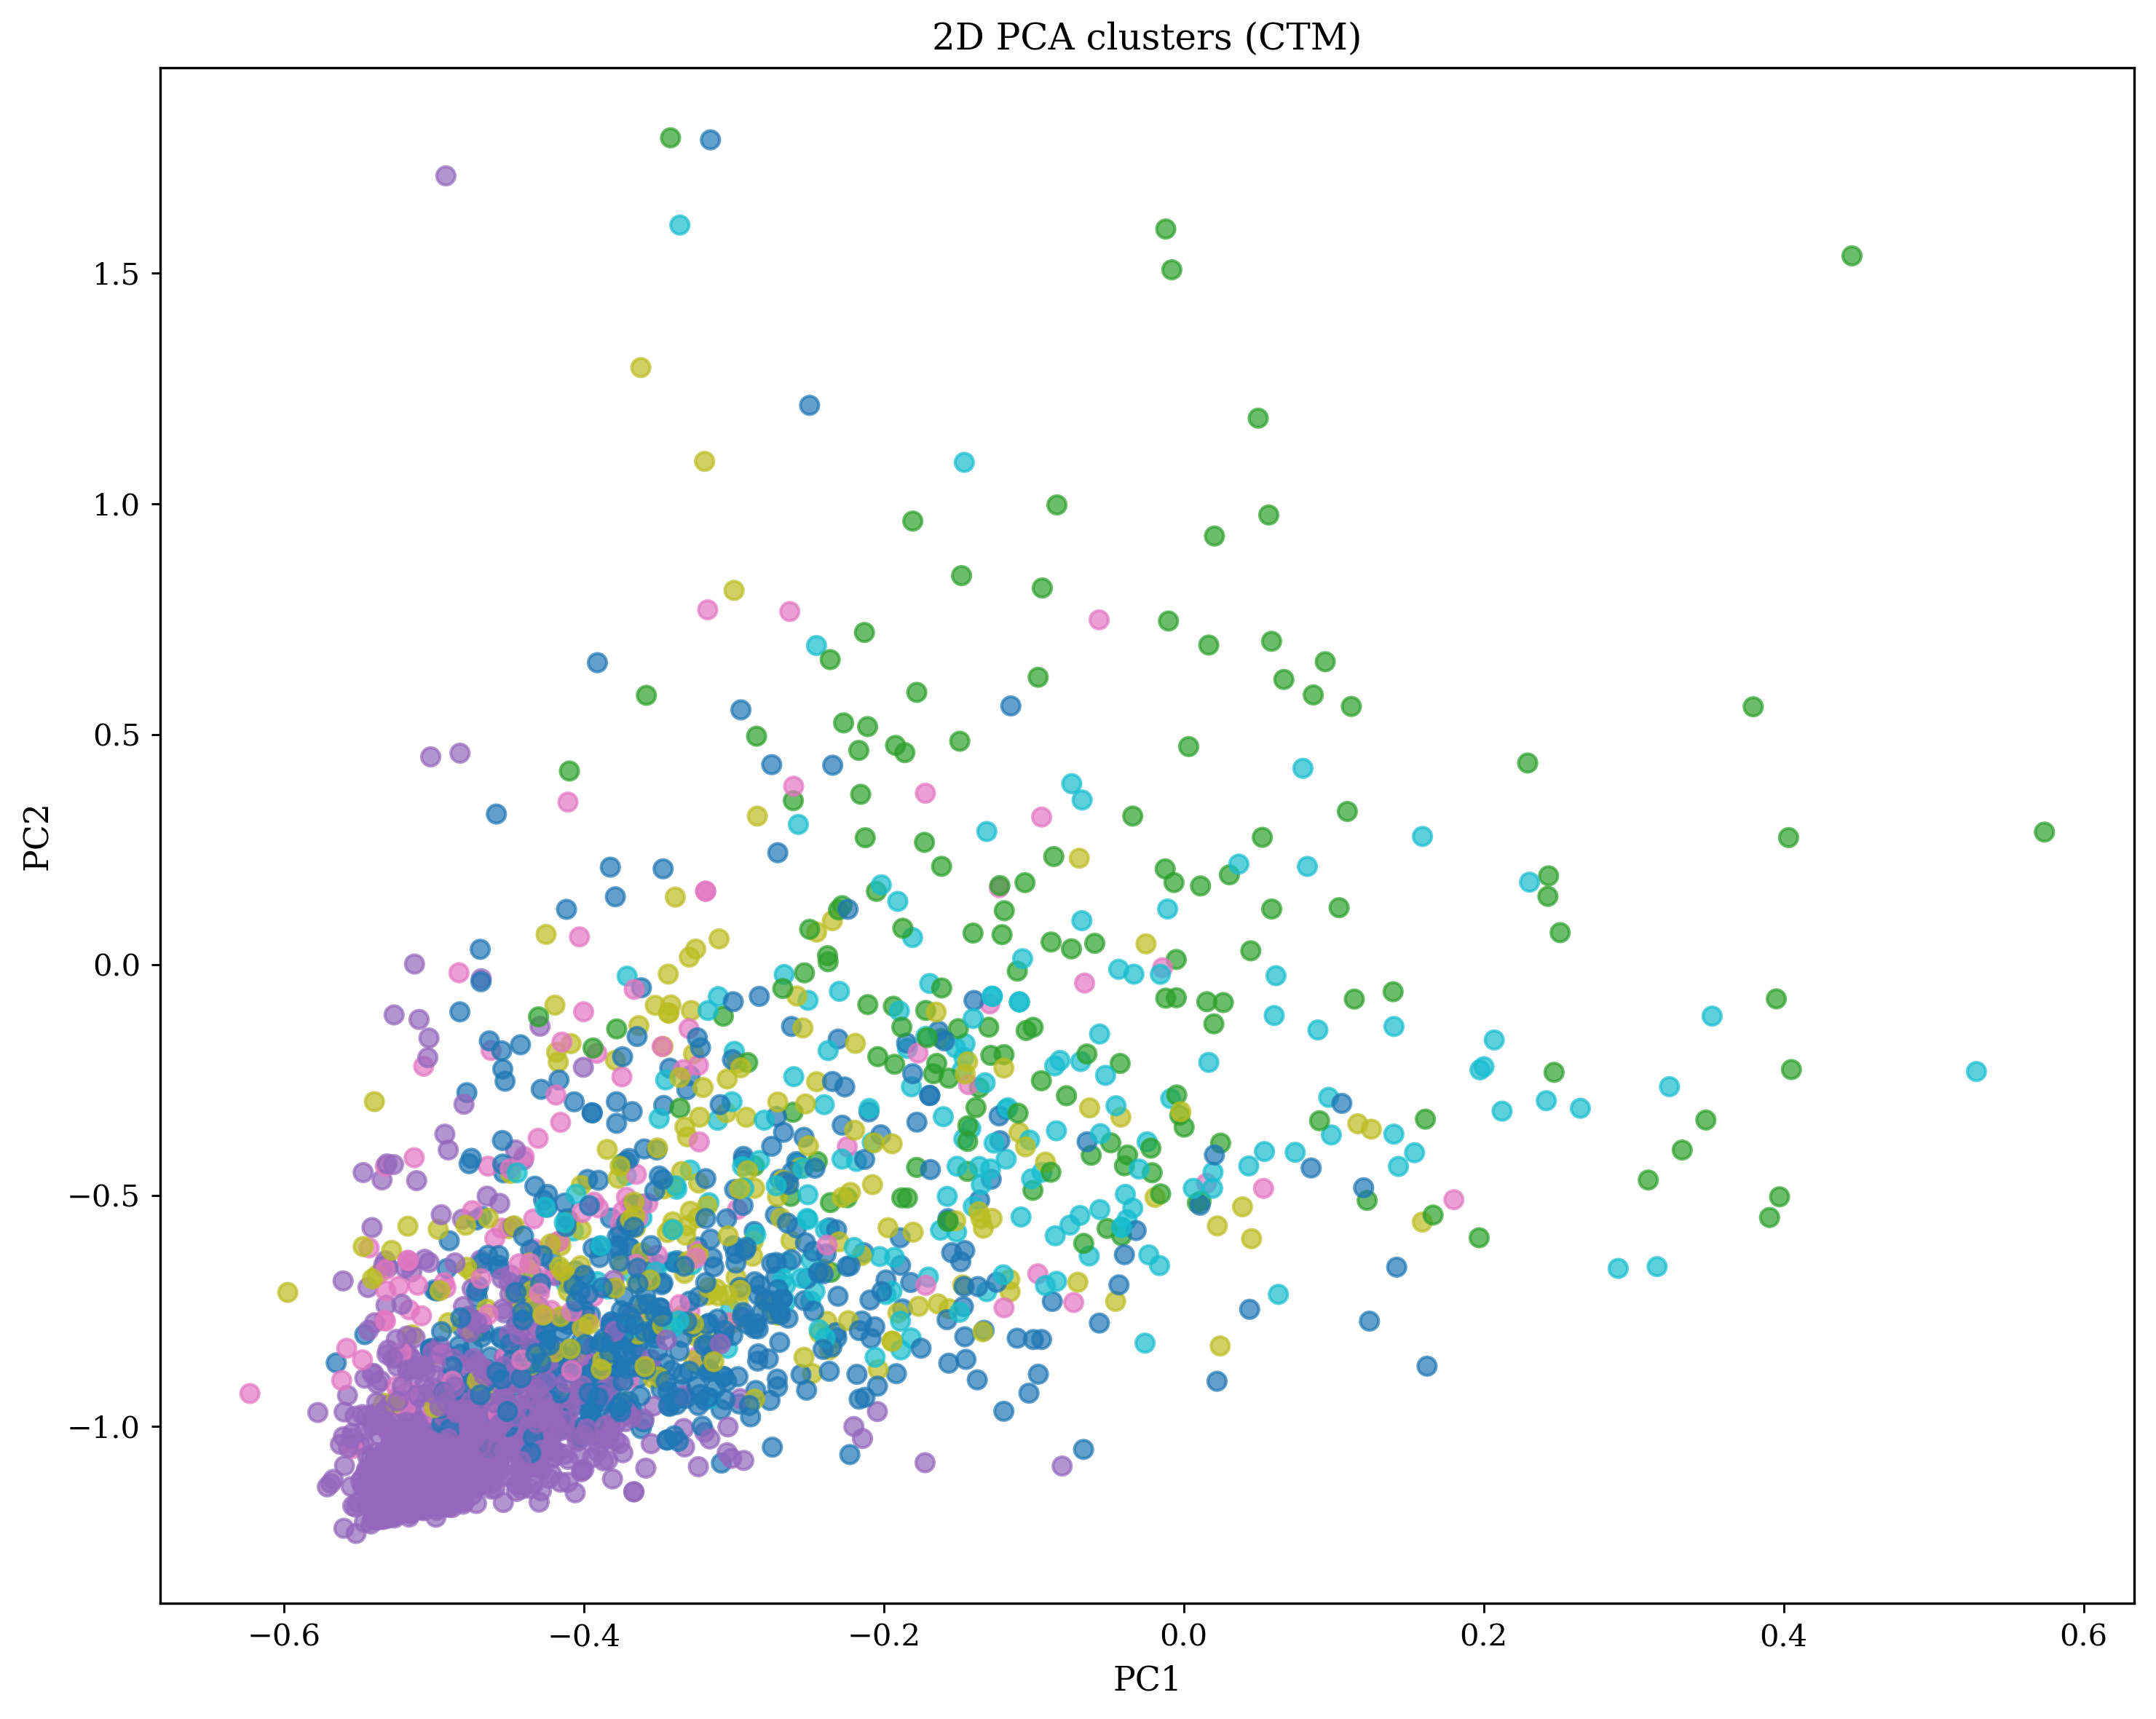

In [105]:
# loading ctms dataset
df = load_ctms_dataset("data/videogame_sequences/sequence_dataset.parquet")

#plot variance explained
plot_variance_explained(df)

# tune clusters
tuning_pipeline_driver()

# plotting the clusters
plotting_pipeline_driver()

# evaluating the metadata
evaluate_metadata(
    df,
    model=KMeans(n_clusters=6, random_state=42),
    save_dir="results/ctms_general/json"
)